In [1]:
from helper.synthesis import create_features_linspace
%load_ext autoreload
%autoreload 2

# import os
# path_parent = os.path.dirname(os.getcwd())
# os.chdir(path_parent)
# os.getcwd()

In [49]:
from analysis.gridbased import model

In [52]:
model_type = 'dense'
parameterization = 'svensson'
models = model.init_model(model_type = model_type, parameterization = parameterization)

Model: "dense_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             multiple                  300       
                                                                 
 dense_9 (Dense)             multiple                  930       
                                                                 
 dense_10 (Dense)            multiple                  930       
                                                                 
 dense_11 (Dense)            multiple                  1953      
                                                                 
 reshape_1 (Reshape)         multiple                  0         
                                                                 
Total params: 4,113
Trainable params: 4,113
Non-trainable params: 0
_________________________________________________________________


In [53]:
import os
os.getcwd()

'/Users/samaypanwar/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/Uni/FYP/FYP-Code'

100%|██████████| 250/250 [02:16<00:00,  1.83it/s]


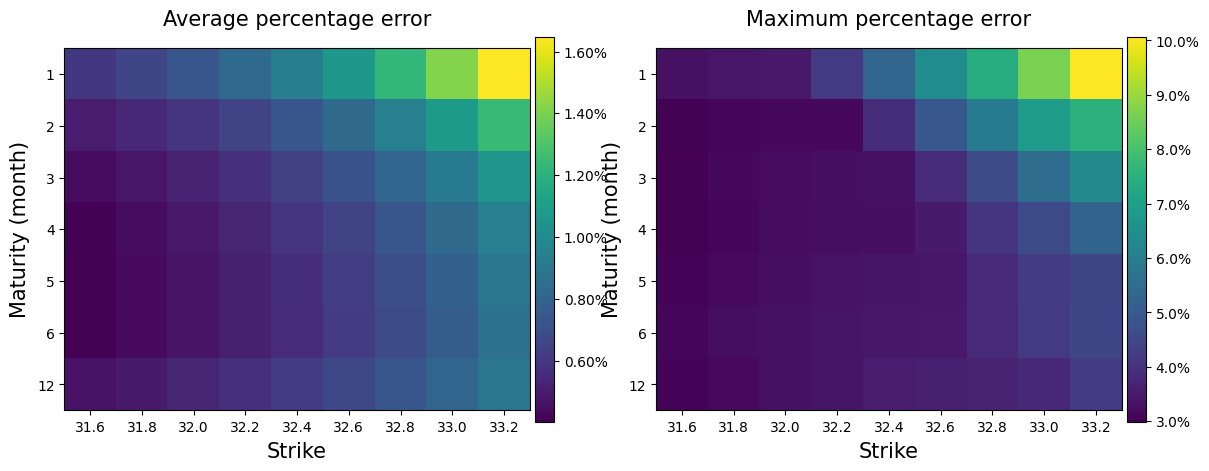

In [54]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
# print(os.getcwd())
model.train_model(models, epochs = 250, model_type = model_type, parameterization = parameterization)

In [56]:
model.load_weights(models, model_type = model_type, parameterization = parameterization)

In [57]:
params_range_train, params_range_test, price_train, price_test = model.load_data(parameterization = parameterization)

In [61]:
model.calibrate(model = models, prices = price_test, parameters = params_range_test, epochs = 1000, model_type = model_type, parameterization = parameterization)

100%|██████████| 1000/1000 [00:04<00:00, 215.02it/s]


In [59]:
params_range_test.shape

(4000, 9)

In [1]:
from helper.synthesis import create_features_linspace
%load_ext autoreload
%autoreload 2


In [2]:
from analysis.pointwise import model

In [3]:
import os
os.getcwd()

'/Users/samaypanwar/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/Uni/FYP/FYP-Code'

In [4]:
parameterization = 'svensson'
pointwise_models = model.init_model(model_type = 'dense', parameterization = parameterization)

Model: "dense_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  360       
                                                                 
 dense_1 (Dense)             multiple                  930       
                                                                 
 dense_2 (Dense)             multiple                  930       
                                                                 
 dense_3 (Dense)             multiple                  31        
                                                                 
Total params: 2,251
Trainable params: 2,251
Non-trainable params: 0
_________________________________________________________________


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


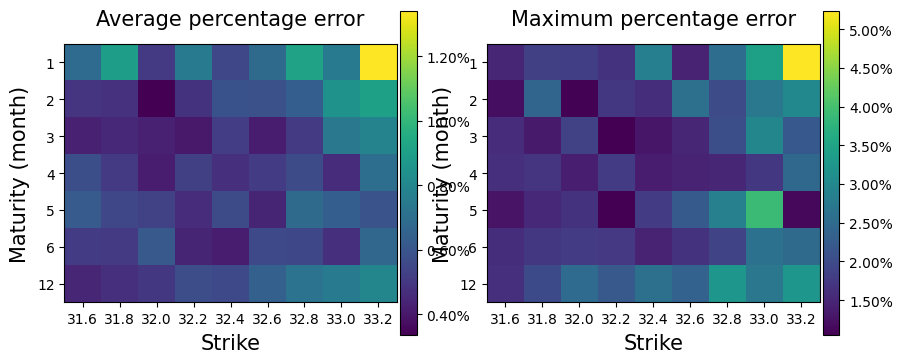

In [5]:
model.train_model(pointwise_models, epochs = 25, model_type = 'dense', parameterization = parameterization)

In [8]:
model.load_weights(pointwise_models, parameterization = parameterization)
params_range_train, params_range_test, price_train, price_test = model.load_data(parameterization = parameterization)

In [10]:
model.calibrate(model = pointwise_models, prices = price_test, parameters = params_range_test[1], parameterization = parameterization
                )

In [7]:
params_range_test.s

(4000, 9)

In [15]:
from helper.parameterizations import SvenssonCurve

In [16]:
sc = SvenssonCurve(parameters = [6.6, -5, -100, 10, -0.5, 1])

In [23]:
sc.calculate_average_integral_curve(0, 3)

5.941631173191975

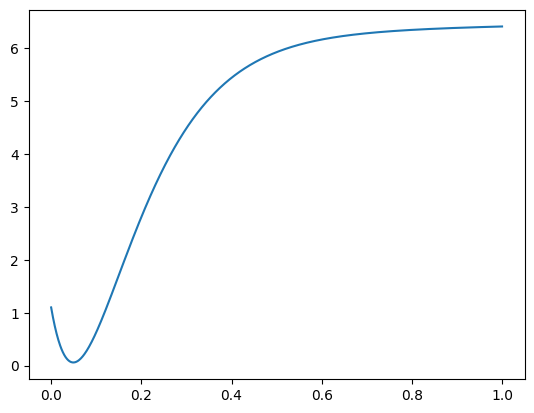

In [41]:
y = []
import numpy as np
x = np.linspace(0, 1, 1001)
for i in x:
  y.append(sc(i))

import matplotlib.pyplot as plt

plt.plot(x, y)

In [46]:
from helper.synthesis import generate_grid_data, generate_pointwise_data

In [47]:
generate_grid_data(parameterization = 'svensson')

100%|██████████| 44000/44000 [19:33<00:00, 37.48it/s]


Data successfully generated!


In [48]:
generate_pointwise_data(parameterization = 'svensson')

Data successfully generated!
